# Field Aligned FPC
Here we show how to make velocity space signatures using the imported libraries. 

In [1]:
import sys

import lib.analysis as anl 
import lib.array_ops as ao
import lib.data_tristan as dtr
import lib.fpc as fpc
import lib.frametransform as ft
import lib.plot.velspace as pltvv

import lib.plot.oned as plt1d

import os
import math
import numpy as np

In [2]:
import ipympl

In [3]:
%matplotlib widget

## Load Data

Here we attempt to normalize distance to d_i and velocity to thermal velocity of each species

To compute the thermal velocity, we use moments of the distribution to compute temperature from which we define thermal velocity as v_rms. This is not perfect by any means but it is good enough for now.

If there is any input file where the injected particles are given some thermal velocity,  we should load that value directly instead.

We also assume beta_i = beta_e = 1 but this only impacts the velocity normalization (as v_thermal != v_a)

In [4]:
normalize = True #Here I attempt to normalize in the same way dHybridR data is normalized. 
                 #WARNING: for now, we normalize E to the average upstream val, which is incorrect but close enough
                 #If left on, I would all quantities with a grain of salt
                 #but, the shapes of the signatures should be the same, so they are still useful

In [5]:
path = '/Users/work/Desktop/random/tempdata/tristan/MA_10_MS_10_mime49_ppc64_comp20/' #make sure to include '/' at end of string
num = '0200'
params = dtr.load_params(path,num)
dfields = dtr.load_fields(path,num,normalizeFields=normalize)
for key in 'ex ey ez bx by bz'.split(): #our functions assume 3D fields. When the fields are 2D, we load the 2D data into two identitical sheets to mimic the 3D data structure
    if(not(key+'_zz' in dfields.keys())):
        dfields[key+'_zz'] = np.asarray([0,1])
    if(not(key+'_yy' in dfields.keys())):
        dfields[key+'_yy'] = np.asarray([0,1])
dpar_elec, dpar_ion = dtr.load_particles(path,num,normalizeVelocity=normalize) #we like to normalize to each species thermal velocity in the upstream. This function will attempt to calculate this use moments of the dist. It's not perfect, but it works for now
dpar_ion = dtr.format_par_like_dHybridR(dpar_ion) #For now, we rename the particle data keys too look like the keys we used when processing dHybridR data so this data is compatible with our old routines
dpar_elec = dtr.format_par_like_dHybridR(dpar_elec)

## Compute Shock Vel and Transform Fields

Text(0, 0.5, '$u_{x,i}$')

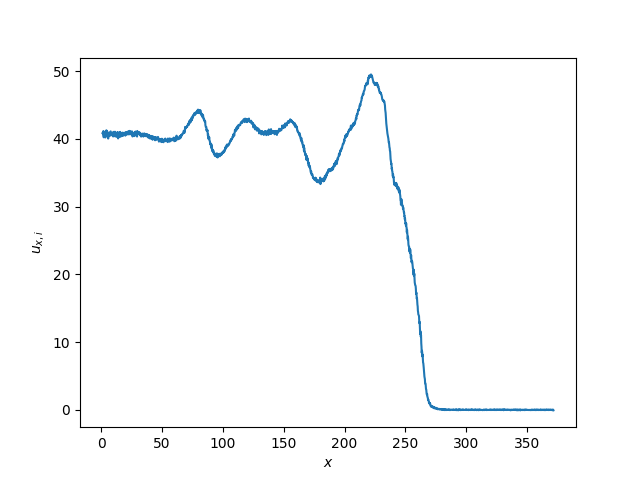

In [6]:
# Use Vassilis' routine to look at the velocity in the upstream frame
from numba import jit, guvectorize, float64
import matplotlib.pyplot as plt
@jit(nopython = True, cache = True)
def CalcVxHists(x, u, bin_width, xmin, vx, counts):
    maxl = len(vx)
    norm = bin_width**-1
    for i in range(len(x)):
        l = int((x[i]-xmin)*norm)
        if l>=0 and l < maxl:
            vx[l] += u[i]
            counts[l] += 1
    for l in range(len(vx)):
        if counts[l] != 0:
            c = counts[l]**-1
            vx[l] *= c

# ---------------------------------------------------------------------
xbn = 2000
xmax = np.max(dpar_ion['x1'])
xmin = np.min(dpar_ion['x1'])

bin_width = (xmax-xmin)/float(xbn)
x_bins = np.linspace(xmin, xmax, num = xbn+1, dtype="float64")

icounts = np.zeros(xbn)
    
vx = np.zeros(xbn)
CalcVxHists(dpar_ion['x1'], dpar_ion['p1'], bin_width, xmin, vx, icounts) 

# ---------------------------------------------------------------------

fig, ax = plt.subplots()
ax.plot(x_bins[0] + np.cumsum(np.diff(x_bins)), vx)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$u_{x,i}$')

In [7]:
#for simplicity, assume the shock velocity is about the velocity of the downstream flow in the frame of the upstream
vshock = 0. #make sure this is in the correct units!

In [8]:
#Lorentz transform fields
dfields = ft.lorentz_transform_vx(dfields,vshock)

#transform data frame
dpar_ion = ft.shift_particles(dpar_ion, vshock)
dpar_elec = ft.shift_particles(dpar_elec, vshock)

## Plot Distribution Functions

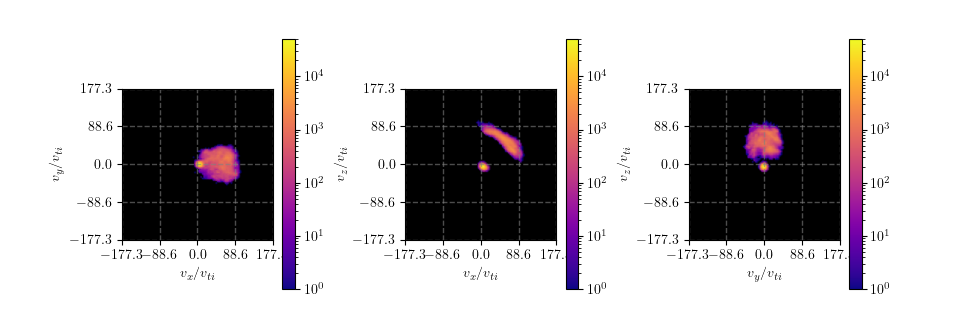

In [9]:
#plot the velocity distribution of all ions located in between xmin_plot xmax_plot

xmin_plot = 245.0
xmax_plot = 250.0

vmax = np.max(dpar_ion['ui']) #max plot extend
dv = vmax/50. #bin size (we use cubes for bins)
vx,vy,vz,H_in = anl.build_dist(dpar_ion,vmax,dv,245.0,250.0,np.min(dpar_ion['x2']),np.max(dpar_ion['x2']),np.min(dpar_ion['x3']),np.max(dpar_ion['x3']))
ax,fig = pltvv.dist_log_plot_3dir(vx, vy, vz, vmax, H_in, flnm = '',ttl='',xlbl=r"$v_x/v_{ti}$",ylbl=r"$v_y/v_{ti}$",zlbl=r"$v_z/v_{ti}$")


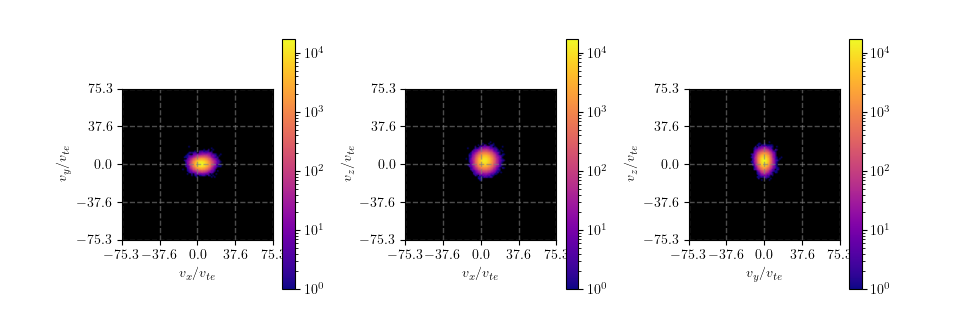

In [10]:
#same as above but for electrons
vmax = np.max(dpar_elec['ue'])
dv = vmax/50.
vx,vy,vz,H_in = anl.build_dist(dpar_elec,vmax,dv,245.0,250.0,np.min(dpar_elec['x2']),np.max(dpar_elec['x2']),np.min(dpar_elec['x3']),np.max(dpar_elec['x3']))
ax,fig = pltvv.dist_log_plot_3dir(vx, vy, vz, vmax, H_in, flnm = '',ttl='',xlbl=r"$v_x/v_{te}$",ylbl=r"$v_y/v_{te}$",zlbl=r"$v_z/v_{te}$")

## Generate FPCs
Here is routine to compute the FPC and plot the velocity signatures between x1 and x2 in the simulation.

In [11]:
def make_FPC_plot(dfields,dpar,dv,vmax,x1,x2,fieldkey,planename,flnm=''):
    
    
    ttl = ''
    directionkey = fieldkey[-1]
    #sets up labels for plot
    if(fieldkey == 'epar'):
        directionkey = 'epar'
        ttl = '$C_{E_{||}}'
    elif(fieldkey == 'eperp1'):
        directionkey = 'eperp1'
        ttl = '$C_{E_{\perp,1}}'
    elif(fieldkey == 'eperp2'):
        directionkey = 'eperp2'
        ttl = '$C_{E_{\perp,2}}'
    elif(fieldkey == 'ex'):
        ttl = '$C_{E_{x}}'
    elif(fieldkey == 'ey'):
        ttl = '$C_{E_{y}}'
    elif(fieldkey == 'ez'):
        ttl = '$C_{E_{z}}'
    
    if(planename == 'parperp1'):
        ttl += '(v_{||},v_{\perp,1})$'
        xlbl = "$v_{||}/v_{ts}$"
        ylbl =  "$v_{\perp,1}/v_{ts}$"
    elif(planename == 'parperp2'):
        ttl += '(v_{||},v_{\perp,2})$'
        xlbl = "$v_{||}/v_{ts}$"
        ylbl =  "$v_{\perp,2}/v_{ts}$"
    elif(planename == 'perp1perp2'):
        ttl += '(v_{\perp,1},v_{\perp,2})$'
        xlbl = "$v_{\perp,1}/v_{ts}$"
        ylbl =  "$v_{\perp,2}/v_{ts}$"
    elif(planename == 'xy'):
        ttl += '(v_x,v_y)$'
        xlbl = "$v_{x}/v_{ts}$"
        ylbl =  "$v_{y}/v_{ts}$"
    elif(planename == 'xz'):
        ttl += '(v_x,v_z)$'
        xlbl = "$v_{x}/v_{ts}$"
        ylbl =  "$v_{z}/v_{ts}$"
    elif(planename == 'yz'):
        ttl += '(v_y,v_z)$'
        xlbl = "$v_{y}/v_{ts}$"
        ylbl =  "$v_{z}/v_{ts}$"
    ttl+='; '
    
    #for now, we use the full yz domain to capture as many particles as possible
    y1 = dfields['ex_yy'][0]
    y2 = dfields['ex_yy'][-1]
    z1 = dfields['ex_zz'][0]
    z2 = dfields['ex_zz'][-1]
        
    #computes FPC
    #note: v1[k,j,i],v2[k,j,i],v3[k,j,i] corresponds to cor[k,j,i]
    #where v1 corresponds to vx/vpar (in stand/fieldaligned)
    #where v2 corresponds to vy/vperp1 (in stand/fieldaligned)
    #where v3 corresponds to vz/vperp2 (in stand/fieldaligned)
    v1, v2, v3, totalPtcl, totalFieldpts, hist, cor = fpc.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2,
                                                                            dpar, dfields, vshock, fieldkey, directionkey)
    del totalFieldpts #this needs to be removed from the code as it is not used anymore

    #makes plot
    CEiproj = ao.array_3d_to_2d(cor, planename)
    return pltvv.plot_velsig(v1,v2,v3,dv,vmax,CEiproj,fieldkey,planename,ttl=ttl,xlabel=xlbl,ylabel=ylbl)
     
    if(flnm != ''):
        return pltvv.plot_velsig(v1,v2,v3,dv,vmax,CEiproj,fieldkey,planename,ttl=ttl,xlabel=xlbl,ylabel=ylbl,flnm=flnm)

In [12]:
#select field we want to correlate with
#options are: ex, ey, ez, epar, eperp1, eperp2
fieldkey = 'epar'

#select velocity plane we want to project onto
#options depend on fieldkey
#if fieldkey is epar, eperp1, or eperp2: select parperp1, parperp2, or perp1perp2
#if fieldkey is ex, ey, or ez: select xy, yz, or xz
planename = 'parperp1'

#set up velocity grid bins
vmax = 50.
dv = 2

#set up integration box (note, we use full extents in y and z)
x1 = 300
x2 = 303

To make electron signatures, replace dpar_ion with dpar_elec below

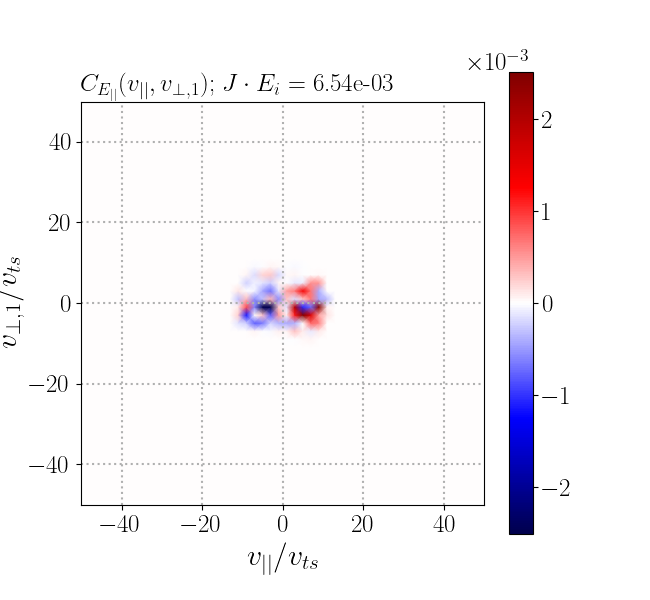

In [13]:
#flnm = ''
flnm = '' #if specified, will save a png of the plot with given filename
ax,fig = make_FPC_plot(dfields,dpar_ion,dv,vmax,x1,x2,fieldkey,planename,flnm=flnm)